In [1]:
pip install fancyimpute

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from fancyimpute import SoftImpute
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
data = pd.read_csv("/content/drive/MyDrive/Dataset/Bankruptcy_Data.csv")
data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,5,6,7,9,10,13,14,15,16,17,21,23,24,25,28,33,34,35,37,47,49,50,56,58) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.096557,0.13718,0.8528,7.2168,710.67,0,0.096557,6.2899,0.61457,0.86282,0.096557,0.70389,0.15711,0.096557,518.55,0.70389,7.2899,0.096557,0.15711,16.644,0.82983,0,0.15711,?,0.80007,0.70389,?,85.04,2.9013,-1.0864,0.35214,119.84,3.0457,3.0457,0.00697,0.61457,?,0.86282,0.011341,5.867,?,0,109.97,93.323,3.4455,7.0125,24.482,0,0,7.2168,0.13718,0.32833,86.04,86.04,679.47,0.32018,0.11191,0.70637,0,21.93,3.9111,81.471,4.4801,61.284,0
1,0.30458,0.13686,0.75567,6.6983,93.503,0,0.37602,6.307,2.49970,0.86314,0.37607,2.8355,0.16257,0.37602,122.93,2.9693,7.307,0.37602,0.15043,26.179,0.65534,0.37291,0.12185,?,0.80077,2.4472,7290.8,6.7644,2.904,-0.041155,0.15045,22.747,16.046,15.548,0.37179,2.4997,?,0.86314,0.14874,2.0459,0.011313,0.14918,90.089,63.91,1.6988,5.3464,30.754,0.34257,0.13705,6.4907,0.13261,0.062322,7.7264,7.7264,605.75,0.14874,0.35287,0.85001,0,13.942,5.7112,19.364,18.849,22.376,0
2,0.13495,0.16866,0.71295,5.2272,432.48,0,0.17653,4.9292,0.76021,0.83134,0.1766,1.0467,0.25226,0.17653,321.01,1.137,5.9292,0.17653,0.23222,0.19961,1.1209,0.10746,0.17752,?,0.55143,0.8905,1747.7,6.0221,3.0373,-0.47358,0.2323,101.19,3.607,3.607,0.15185,0.76021,?,0.83134,0.19975,3.1346,0.045818,0.14136,169.45,169.25,324.61,5.2248,0.24944,0.092228,0.12132,5.2272,0.16866,0.27724,7.0221,7.0221,776.85,0.19975,0.16233,0.85872,0,1828.5,2.1565,80.978,4.5074,6.4212,0
3,0.26775,0.11341,0.78931,8.0405,213.67,0,0.33261,7.8176,1.70250,0.88659,0.33261,2.9668,0.22367,0.33261,108.7,3.3578,8.8176,0.33261,0.19536,0,0.73416,0.33258,0.15727,?,0.62958,2.786,?,8.0063,2.289,-0.29154,0.19536,29.871,12.219,12.079,0.33267,1.7025,?,0.88659,0.1954,5.4824,0.009928,0.19534,61.483,61.483,?,8.0405,0,0.28437,0.16703,7.9483,0.11211,0.081839,8.9931,8.9931,153.55,0.1954,0.302,0.80466,0,?,5.9366,24.035,15.186,17.27,0
4,0.046283,0.094199,0.47172,7.6622,88.809,0,0.046283,9.6158,1.13950,0.9058,0.046283,0.65366,0.064559,0.046283,467.39,0.78093,10.616,0.046283,0.040618,54.234,0.99457,0.030548,0.040618,?,0.86719,0.78093,40348,1.0311,3.1208,-0.081241,0.040618,23.383,15.61,11.733,0.034208,1.1395,?,0.9058,0.030021,3.153,0.054298,0.026809,102.27,48.037,0.27336,5.271,55.913,0.003268,0.002868,5.7594,0.070806,0.064062,1.98,1.98,623.05,0.030021,0.051096,0.95994,0,6.7301,7.5983,22.681,16.093,2.4908,0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data.shape

(9539, 65)

In [6]:
# Replacing the null values (which are question marks) to np.nan
k=data.columns.tolist()
for i in k:
    data[i] = data[i].replace('?', np.nan)

In [7]:
# To give an idea of the number of null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9539 entries, 0 to 9538
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Attr1   9538 non-null   object 
 1   Attr2   9538 non-null   object 
 2   Attr3   9538 non-null   object 
 3   Attr4   9497 non-null   object 
 4   Attr5   9519 non-null   object 
 5   Attr6   9538 non-null   object 
 6   Attr7   9538 non-null   object 
 7   Attr8   9520 non-null   object 
 8   Attr9   9539 non-null   float64
 9   Attr10  9538 non-null   object 
 10  Attr11  9538 non-null   object 
 11  Attr12  9497 non-null   object 
 12  Attr13  9518 non-null   object 
 13  Attr14  9538 non-null   object 
 14  Attr15  9531 non-null   object 
 15  Attr16  9520 non-null   object 
 16  Attr17  9520 non-null   object 
 17  Attr18  9538 non-null   object 
 18  Attr19  9518 non-null   object 
 19  Attr20  9518 non-null   object 
 20  Attr21  9383 non-null   object 
 21  Attr22  9538 non-null   object 
 22  

In [8]:
# Gives statistical information on the dataset
data.describe()

,Attr9,Attr55,class
count,9539.000000,9.539000e+03,9539.000000
mean,1.895361,7.695430e+03,0.053989
std,17.906907,7.686359e+04,0.226008
min,-0.032371,-7.132200e+05,0.000000
25%,1.006750,1.593450e+01,0.000000
50%,1.163400,9.220500e+02,0.000000
75%,1.977750,4.582700e+03,0.000000
max,1704.800000,6.123700e+06,1.000000


In [9]:
# Number of missing values for every attribute
missing_values = data.isna().sum()
missing_values.sort_values(ascending=False)

Attr37    4317
Attr27     636
Attr60     603
Attr45     602
Attr28     224
          ... 
Attr57       1
Attr59       1
Attr9        0
Attr55       0
class        0
Length: 65, dtype: int64

In [10]:
classes = data['class']
data_temp = data.drop(columns='class')
data_temp.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
0,0.096557,0.13718,0.8528,7.2168,710.67,0,0.096557,6.2899,0.61457,0.86282,0.096557,0.70389,0.15711,0.096557,518.55,0.70389,7.2899,0.096557,0.15711,16.644,0.82983,0,0.15711,NaN,0.80007,0.70389,NaN,85.04,2.9013,-1.0864,0.35214,119.84,3.0457,3.0457,0.00697,0.61457,NaN,0.86282,0.011341,5.867,NaN,0,109.97,93.323,3.4455,7.0125,24.482,0,0,7.2168,0.13718,0.32833,86.04,86.04,679.47,0.32018,0.11191,0.70637,0,21.93,3.9111,81.471,4.4801,61.284
1,0.30458,0.13686,0.75567,6.6983,93.503,0,0.37602,6.307,2.49970,0.86314,0.37607,2.8355,0.16257,0.37602,122.93,2.9693,7.307,0.37602,0.15043,26.179,0.65534,0.37291,0.12185,NaN,0.80077,2.4472,7290.8,6.7644,2.904,-0.041155,0.15045,22.747,16.046,15.548,0.37179,2.4997,NaN,0.86314,0.14874,2.0459,0.011313,0.14918,90.089,63.91,1.6988,5.3464,30.754,0.34257,0.13705,6.4907,0.13261,0.062322,7.7264,7.7264,605.75,0.14874,0.35287,0.85001,0,13.942,5.7112,19.364,18.849,22.376
2,0.13495,0.16866,0.71295,5.2272,432.48,0,0.17653,4.9292,0.76021,0.83134,0.1766,1.0467,0.25226,0.17653,321.01,1.137,5.9292,0.17653,0.23222,0.19961,1.1209,0.10746,0.17752,NaN,0.55143,0.8905,1747.7,6.0221,3.0373,-0.47358,0.2323,101.19,3.607,3.607,0.15185,0.76021,NaN,0.83134,0.19975,3.1346,0.045818,0.14136,169.45,169.25,324.61,5.2248,0.24944,0.092228,0.12132,5.2272,0.16866,0.27724,7.0221,7.0221,776.85,0.19975,0.16233,0.85872,0,1828.5,2.1565,80.978,4.5074,6.4212
3,0.26775,0.11341,0.78931,8.0405,213.67,0,0.33261,7.8176,1.70250,0.88659,0.33261,2.9668,0.22367,0.33261,108.7,3.3578,8.8176,0.33261,0.19536,0,0.73416,0.33258,0.15727,NaN,0.62958,2.786,NaN,8.0063,2.289,-0.29154,0.19536,29.871,12.219,12.079,0.33267,1.7025,NaN,0.88659,0.1954,5.4824,0.009928,0.19534,61.483,61.483,NaN,8.0405,0,0.28437,0.16703,7.9483,0.11211,0.081839,8.9931,8.9931,153.55,0.1954,0.302,0.80466,0,NaN,5.9366,24.035,15.186,17.27
4,0.046283,0.094199,0.47172,7.6622,88.809,0,0.046283,9.6158,1.13950,0.9058,0.046283,0.65366,0.064559,0.046283,467.39,0.78093,10.616,0.046283,0.040618,54.234,0.99457,0.030548,0.040618,NaN,0.86719,0.78093,40348,1.0311,3.1208,-0.081241,0.040618,23.383,15.61,11.733,0.034208,1.1395,NaN,0.9058,0.030021,3.153,0.054298,0.026809,102.27,48.037,0.27336,5.271,55.913,0.003268,0.002868,5.7594,0.070806,0.064062,1.98,1.98,623.05,0.030021,0.051096,0.95994,0,6.7301,7.5983,22.681,16.093,2.4908


In [11]:
# Normalize the dataset to bring all the values in the same range
scaler = StandardScaler()
data_norm = pd.DataFrame(scaler.fit_transform(data_temp), columns = data_temp.columns)
data_norm['class'] = classes
data_norm.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.148206,-0.099497,0.157091,-0.003575,0.043139,0.008989,0.068991,-0.019838,-0.071529,0.102527,0.039499,0.006637,-0.006501,0.068965,-0.024732,0.001071,-0.019967,0.042875,0.006862,-0.120802,-0.065288,-0.129792,0.009514,NaN,0.118400,0.003399,NaN,0.522457,-1.201537,-0.019030,0.012002,-0.036536,-0.077540,-0.033546,-0.103939,-0.084018,NaN,0.081375,0.014261,0.030861,NaN,0.026633,-0.019275,-0.017902,-0.010368,-0.001340,-0.044428,0.005002,0.033302,0.000049,-0.072365,-0.010956,0.878477,0.531677,-0.091283,0.017187,0.008492,-0.053144,-0.032754,-0.029472,-0.019539,-0.016717,-0.068872,0.055909,0
1,0.721487,-0.099566,0.136060,-0.005336,0.001864,0.008989,0.587013,-0.019814,0.033751,0.102595,0.562633,0.034978,-0.006359,0.586986,-0.028553,0.029557,-0.019943,0.417902,0.006604,-0.095844,-0.094326,0.601054,0.008057,NaN,0.118542,0.026640,0.192852,-0.000873,-1.198420,-0.016005,0.004221,-0.052131,0.106634,0.177506,0.642413,0.023284,NaN,0.081444,0.016021,-0.012040,-0.023308,0.037020,-0.019873,-0.018787,-0.019656,-0.006998,-0.041322,0.650133,0.041898,-0.002441,-0.073356,-0.011249,0.016096,0.001007,-0.092242,0.014990,0.035082,-0.035506,-0.032754,-0.031914,-0.017922,-0.017241,0.164337,-0.026633,0
2,0.254011,-0.092723,0.126811,-0.010332,0.024534,0.008989,0.217231,-0.021761,-0.063395,0.095757,0.189307,0.011195,-0.004027,0.217205,-0.026640,0.006517,-0.021889,0.150195,0.009760,-0.163844,-0.016850,0.080813,0.010357,NaN,0.067819,0.005887,0.018931,-0.005835,-1.044570,-0.017256,0.007379,-0.039532,-0.069589,-0.024070,0.192458,-0.075728,NaN,0.074588,0.016675,0.000184,-0.022481,0.036476,-0.017487,-0.015618,1.697505,-0.007411,-0.056429,0.178687,0.040911,-0.006775,-0.065543,-0.011012,0.008341,-0.003765,-0.090016,0.015644,0.014056,-0.034436,-0.032754,0.522878,-0.021114,-0.016722,-0.068429,-0.060481,0
3,0.619989,-0.104612,0.143344,-0.000778,0.009900,0.008989,0.506546,-0.017680,-0.010771,0.107638,0.481294,0.036724,-0.004771,0.506520,-0.028690,0.034442,-0.017809,0.359648,0.008338,-0.164367,-0.081209,0.522013,0.009520,NaN,0.083717,0.031157,NaN,0.007430,-1.908234,-0.016729,0.005954,-0.050986,0.052417,0.118946,0.562381,-0.022093,NaN,0.086500,0.016619,0.026543,-0.023341,0.040235,-0.020733,-0.018860,NaN,0.002152,-0.056552,0.540530,0.043778,0.002558,-0.077798,-0.011227,0.030045,0.009591,-0.098125,0.015588,0.029468,-0.041074,-0.032754,NaN,-0.017720,-0.017201,0.104886,-0.037465,0
4,0.009658,-0.108746,0.074580,-0.002063,0.001550,0.008989,-0.024199,-0.015140,-0.042213,0.111769,-0.054593,0.005969,-0.008906,-0.024225,-0.025226,0.002039,-0.015269,-0.024591,0.002368,-0.022411,-0.037873,-0.069923,0.004701,NaN,0.132054,0.004426,1.230053,-0.039204,-0.948197,-0.016121,-0.000016,-0.052028,0.100457,0.113105,-0.048215,-0.054139,NaN,0.090642,0.014500,0.000390,-0.022278,0.028499,-0.019507,-0.019264,-0.027236,-0.007255,-0.028862,0.011157,0.033482,-0.004949,-0.086749,-0.011247,-0.047183,-0.037931,-0.092017,0.013468,0.001781,-0.022007,-0.032754,-0.034119,-0.016228,-0.017213,0.119606,-0.068819,0


Class 0: 94.6%
Class 1: 5.4%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


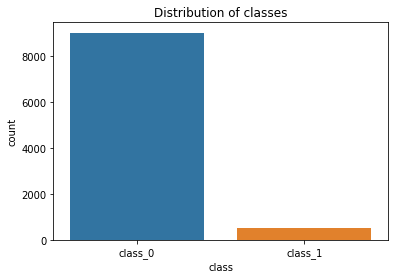

In [12]:
# Visualize the data imbalance
labels = ['class_0', 'class_1']
classes = pd.value_counts(data_norm['class'], sort=True)
classes.plot(kind = 'bar', rot=0)
plt.title("Distribution of classes")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

g = sns.countplot(data_norm['class'])
g.set_xticklabels(labels)

total = data_norm.shape[0]
class_0 = data_norm[data_norm['class'] == 0]
class_1 = data_norm[data_norm['class'] == 1]
print("Class 0: {}%".format(round(len(class_0)*100/total,2)))
print("Class 1: {}%".format(round(len(class_1)*100/total,2)))

# KNN Imputation with NearMiss

In [13]:
# Applying KNN Imputation in order to solve the missing values problem
start_time = time.time()
imp = KNNImputer(n_neighbors=3)
knnImputedDf = pd.DataFrame(imp.fit_transform(data_norm),columns = data_norm.columns)
print("--- %s seconds ---" % (time.time() - start_time))

--- 9.679074764251709 seconds ---


In [14]:
# Check if any null values exist
d = knnImputedDf.isna().sum()
d.sort_values(ascending=False)

class     0
Attr32    0
Attr30    0
Attr29    0
Attr28    0
         ..
Attr38    0
Attr37    0
Attr36    0
Attr35    0
Attr1     0
Length: 65, dtype: int64

In [15]:
# Splitting the dataset for training and validation
X = knnImputedDf.loc[:, knnImputedDf.columns != 'class'].to_numpy()
y = knnImputedDf['class'].to_numpy().reshape(-1, 1)
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2)
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(7631, 64)
(1908, 64)
(7631, 1)
(1908, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit

After Undersampling, counts of label '1': 415
After Undersampling, counts of label '0': 415


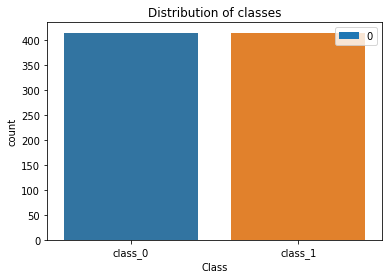

In [16]:
# Performing NearMiss on the dataset to address the problem of imbalanced data
nm = NearMiss()
train_X, train_y = nm.fit_sample(train_X, train_y.ravel())

labels = ['class_0', 'class_1']
classes = pd.DataFrame([sum(train_y == 0), sum(train_y == 1)])
classes.plot(kind = 'bar', rot=0)
plt.title("Distribution of classes")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

g = sns.countplot(train_y)
g.set_xticklabels(labels)

print("After Undersampling, counts of label '1': {}".format(sum(train_y == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(train_y == 0)))

In [17]:
# Performing Logistic Regression on the data after imputation and balancing
start_time = time.time()
model = LogisticRegression(random_state=0, max_iter=400).fit(train_X, train_y.ravel())
scores = cross_val_score(model, train_X, train_y, cv=10)
print('Cross-Validation Accuracy Scores', scores)
print("--- %s seconds ---" % (time.time() - start_time))

Cross-Validation Accuracy Scores [0.78313253 0.77108434 0.78313253 0.80722892 0.77108434 0.79518072
 0.84337349 0.81927711 0.68674699 0.81927711]
--- 0.2381293773651123 seconds ---


In [18]:
# Average training accuracy 
scores.mean()

0.7879518072289157

In [19]:
# Predict values according to the test set given and find the accuracy
pred_y = model.predict(test_X)
print(accuracy_score(test_y, pred_y))

0.6048218029350105


In [20]:
confusion_matrix(test_y, pred_y)

array([[1087,  721],
       [  33,   67]])

In [21]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.97      0.60      0.74      1808
         1.0       0.09      0.67      0.15       100

    accuracy                           0.60      1908
   macro avg       0.53      0.64      0.45      1908
weighted avg       0.92      0.60      0.71      1908



# KNN Imputation with SMOTE

In [22]:
# Splitting the dataset for training and validation
X = knnImputedDf.loc[:, knnImputedDf.columns != 'class'].to_numpy()
y = knnImputedDf['class'].to_numpy().reshape(-1, 1)
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


After Oversampling, counts of label '1': 7218
After Oversampling, counts of label '0': 7218


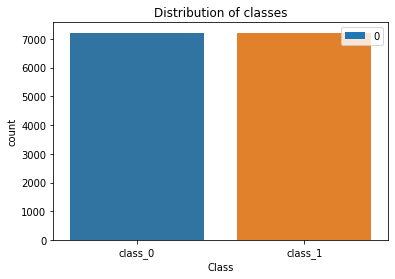

In [23]:
# Performing SMOTE on the dataset to address the problem of imbalanced data
sm = SMOTE(random_state = 2)
train_X, train_y = sm.fit_sample(train_X, train_y.ravel())

labels = ['class_0', 'class_1']
classes = pd.DataFrame([sum(train_y == 0), sum(train_y == 1)])
classes.plot(kind = 'bar', rot=0)
plt.title("Distribution of classes")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

g = sns.countplot(train_y)
g.set_xticklabels(labels)

print("After Oversampling, counts of label '1': {}".format(sum(train_y == 1)))
print("After Oversampling, counts of label '0': {}".format(sum(train_y == 0)))

In [24]:
# Performing Logistic Regression on the data after balancing it
start_time = time.time()
model = LogisticRegression(random_state=0, max_iter=400).fit(train_X, train_y.ravel())
scores = cross_val_score(model, train_X, train_y, cv=10)
print('Cross-Validation Accuracy Scores', scores)
print("--- %s seconds ---" % (time.time() - start_time))

Cross-Validation Accuracy Scores [0.69875346 0.68698061 0.7098338  0.69459834 0.7001385  0.69598338
 0.72072072 0.71032571 0.70824671 0.7040887 ]
--- 8.211386919021606 seconds ---


In [25]:
# Average training accuracy 
scores.mean()

0.7029669932024503

In [26]:
# Predict values according to the test set given and find the accuracy
pred_y = model.predict(test_X)
print(accuracy_score(test_y, pred_y))

0.7190775681341719


In [27]:
confusion_matrix(test_y, pred_y)

array([[1312,  494],
       [  42,   60]])

In [28]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83      1806
         1.0       0.11      0.59      0.18       102

    accuracy                           0.72      1908
   macro avg       0.54      0.66      0.51      1908
weighted avg       0.92      0.72      0.80      1908



# Mean Imputation with SMOTE

In [29]:
start_time = time.time()
miss_mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
miss_mean_imputer = miss_mean_imputer.fit(data_norm)
mean_imputed_df = miss_mean_imputer.transform(data_norm.values)
print("--- %s seconds ---" % (time.time() - start_time))
mean_imputed_df = pd.DataFrame(mean_imputed_df,columns = data_norm.columns)
mean_imputed_df

--- 0.026357412338256836 seconds ---


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.148206,-0.099497,0.157091,-0.003575,0.043139,0.008989,0.068991,-0.019838,-0.071529,0.102527,0.039499,0.006637,-0.006501,0.068965,-0.024732,0.001071,-0.019967,0.042875,0.006862,-0.120802,-0.065288,-0.129792,0.009514,1.501094e-18,0.118400,0.003399,5.985702e-18,0.522457,-1.201537,-0.019030,0.012002,-0.036536,-0.077540,-0.033546,-0.103939,-0.084018,1.496739e-17,0.081375,0.014261,0.030861,7.593702e-19,0.026633,-0.019275,-0.017902,-0.010368,-0.001340,-0.044428,0.005002,0.033302,0.000049,-0.072365,-0.010956,0.878477,0.531677,-0.091283,0.017187,0.008492,-0.053144,-0.032754,-2.947182e-02,-0.019539,-0.016717,-0.068872,0.055909,0.0
1,0.721487,-0.099566,0.136060,-0.005336,0.001864,0.008989,0.587013,-0.019814,0.033751,0.102595,0.562633,0.034978,-0.006359,0.586986,-0.028553,0.029557,-0.019943,0.417902,0.006604,-0.095844,-0.094326,0.601054,0.008057,1.501094e-18,0.118542,0.026640,1.928516e-01,-0.000873,-1.198420,-0.016005,0.004221,-0.052131,0.106634,0.177506,0.642413,0.023284,1.496739e-17,0.081444,0.016021,-0.012040,-2.330825e-02,0.037020,-0.019873,-0.018787,-0.019656,-0.006998,-0.041322,0.650133,0.041898,-0.002441,-0.073356,-0.011249,0.016096,0.001007,-0.092242,0.014990,0.035082,-0.035506,-0.032754,-3.191411e-02,-0.017922,-0.017241,0.164337,-0.026633,0.0
2,0.254011,-0.092723,0.126811,-0.010332,0.024534,0.008989,0.217231,-0.021761,-0.063395,0.095757,0.189307,0.011195,-0.004027,0.217205,-0.026640,0.006517,-0.021889,0.150195,0.009760,-0.163844,-0.016850,0.080813,0.010357,1.501094e-18,0.067819,0.005887,1.893149e-02,-0.005835,-1.044570,-0.017256,0.007379,-0.039532,-0.069589,-0.024070,0.192458,-0.075728,1.496739e-17,0.074588,0.016675,0.000184,-2.248130e-02,0.036476,-0.017487,-0.015618,1.697505,-0.007411,-0.056429,0.178687,0.040911,-0.006775,-0.065543,-0.011012,0.008341,-0.003765,-0.090016,0.015644,0.014056,-0.034436,-0.032754,5.228780e-01,-0.021114,-0.016722,-0.068429,-0.060481,0.0
3,0.619989,-0.104612,0.143344,-0.000778,0.009900,0.008989,0.506546,-0.017680,-0.010771,0.107638,0.481294,0.036724,-0.004771,0.506520,-0.028690,0.034442,-0.017809,0.359648,0.008338,-0.164367,-0.081209,0.522013,0.009520,1.501094e-18,0.083717,0.031157,5.985702e-18,0.007430,-1.908234,-0.016729,0.005954,-0.050986,0.052417,0.118946,0.562381,-0.022093,1.496739e-17,0.086500,0.016619,0.026543,-2.334144e-02,0.040235,-0.020733,-0.018860,0.000000,0.002152,-0.056552,0.540530,0.043778,0.002558,-0.077798,-0.011227,0.030045,0.009591,-0.098125,0.015588,0.029468,-0.041074,-0.032754,5.367238e-18,-0.017720,-0.017201,0.104886,-0.037465,0.0
4,0.009658,-0.108746,0.074580,-0.002063,0.001550,0.008989,-0.024199,-0.015140,-0.042213,0.111769,-0.054593,0.005969,-0.008906,-0.024225,-0.025226,0.002039,-0.015269,-0.024591,0.002368,-0.022411,-0.037873,-0.069923,0.004701,1.501094e-18,0.132054,0.004426,1.230053e+00,-0.039204,-0.948197,-0.016121,-0.000016,-0.052028,0.100457,0.113105,-0.048215,-0.054139,1.496739e-17,0.090642,0.014500,0.000390,-2.227806e-02,0.028499,-0.019507,-0.019264,-0.027236,-0.007255,-0.028862,0.011157,0.033482,-0.004949,-0.086749,-0.011247,-0.047183,-0.037931,-0.092017,0.013468,0.001781,-0.022007,-0.032754,-3.411911e-02,-0.016228,-0.017213,0.119606,-0.068819,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9534,-0.105005,-0.010771,0.014191,-0.023364,-0.007002,0.009667,-0.085889,-0.027613,-0.051627,0.009892,-0.116882,-0.002372,-0

In [30]:
X = mean_imputed_df.loc[:, mean_imputed_df.columns != 'class'].to_numpy()
y = mean_imputed_df['class'].to_numpy().reshape(-1, 1)
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


After Oversampling, counts of label '1': 7211
After Oversampling, counts of label '0': 7211


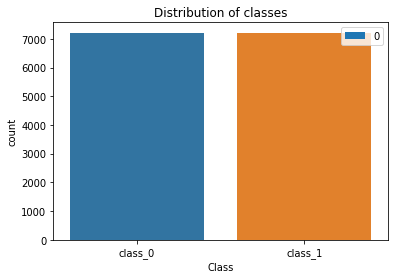

In [31]:
# Performing SMOTE on the dataset to address the problem of imbalanced data
sm = SMOTE(random_state = 2)
train_X, train_y = sm.fit_resample(train_X, train_y.ravel())

labels = ['class_0', 'class_1']
classes = pd.DataFrame([sum(train_y == 0), sum(train_y == 1)])
classes.plot(kind = 'bar', rot=0)
plt.title("Distribution of classes")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

g = sns.countplot(train_y)
g.set_xticklabels(labels)

print("After Oversampling, counts of label '1': {}".format(sum(train_y == 1)))
print("After Oversampling, counts of label '0': {}".format(sum(train_y == 0)))

In [32]:
start_time = time.time()
model = LogisticRegression(random_state=0, max_iter=400).fit(train_X, train_y.ravel())
scores = cross_val_score(model, train_X, train_y, cv=10)
print('Cross-Validation Accuracy Scores', scores)
print("--- %s seconds ---" % (time.time() - start_time))

Cross-Validation Accuracy Scores [0.70893971 0.73250173 0.70665742 0.7260749  0.72052705 0.70457698
 0.71983356 0.71012483 0.70249653 0.72052705]
--- 6.416605472564697 seconds ---


In [33]:
scores.mean()

0.7152259749347128

In [34]:
pred_y = model.predict(test_X)
print(accuracy_score(test_y, pred_y))

0.749475890985325


In [35]:
confusion_matrix(test_y, pred_y)

array([[1372,  441],
       [  37,   58]])

In [36]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85      1813
         1.0       0.12      0.61      0.20        95

    accuracy                           0.75      1908
   macro avg       0.54      0.68      0.52      1908
weighted avg       0.93      0.75      0.82      1908



# Mean Imputation With Near Miss

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit

After Undersampling, counts of label '1': 7211
After Undersampling, counts of label '0': 7211


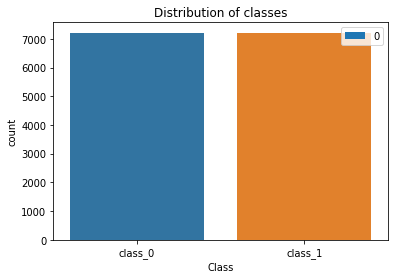

In [37]:
# Performing NearMiss on the dataset to address the problem of imbalanced data
nm = NearMiss()
train_X, train_y = nm.fit_sample(train_X, train_y.ravel())

labels = ['class_0', 'class_1']
classes = pd.DataFrame([sum(train_y == 0), sum(train_y == 1)])
classes.plot(kind = 'bar', rot=0)
plt.title("Distribution of classes")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

g = sns.countplot(train_y)
g.set_xticklabels(labels)

print("After Undersampling, counts of label '1': {}".format(sum(train_y == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(train_y == 0)))

In [38]:
# Performing Logistic Regression on the data after imputation and balancing
start_time = time.time()
model = LogisticRegression(random_state=0, max_iter=400).fit(train_X, train_y.ravel())
scores = cross_val_score(model, train_X, train_y, cv=10)
print('Cross-Validation Accuracy Scores', scores)
print("--- %s seconds ---" % (time.time() - start_time))

Cross-Validation Accuracy Scores [0.4954955  0.56756757 0.67545076 0.72815534 0.7739251  0.69070735
 0.73231623 0.77600555 0.79680999 0.69556172]
--- 6.115804195404053 seconds ---


In [39]:
# Average training accuracy 
scores.mean()

0.6931995101898015

In [40]:
# Predict values according to the test set given and find the accuracy
pred_y = model.predict(test_X)
print(accuracy_score(test_y, pred_y))

0.749475890985325


In [41]:
confusion_matrix(test_y, pred_y)

array([[1372,  441],
       [  37,   58]])

In [42]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85      1813
         1.0       0.12      0.61      0.20        95

    accuracy                           0.75      1908
   macro avg       0.54      0.68      0.52      1908
weighted avg       0.93      0.75      0.82      1908




# Soft Impute with SMOTE

In [43]:
start_time = time.time()
clf = SoftImpute(verbose=0)
new_df = clf.fit_transform(data_norm)
print("--- %s seconds ---" % (time.time() - start_time))

--- 6.40549898147583 seconds ---


In [44]:
y = new_df[:,-1]
X = np.delete(new_df,-1,axis = 1)
train_X,test_X,train_y,test_y = train_test_split(X,y,test_size=0.2)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


After Oversampling, counts of label '1': 7211
After Oversampling, counts of label '0': 7211


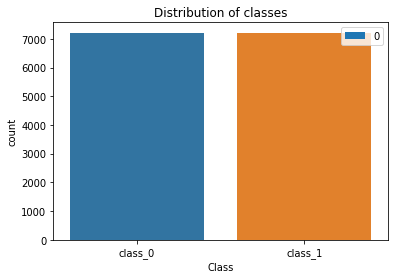

In [45]:
#after using SMOTE
sm = SMOTE(random_state = 2)
train_X, train_y = sm.fit_sample(train_X, train_y.ravel())

labels = ['class_0', 'class_1']
classes = pd.DataFrame([sum(train_y == 0), sum(train_y == 1)])
classes.plot(kind = 'bar', rot=0)
plt.title("Distribution of classes")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

g = sns.countplot(train_y)
g.set_xticklabels(labels)

print("After Oversampling, counts of label '1': {}".format(sum(train_y == 1)))
print("After Oversampling, counts of label '0': {}".format(sum(train_y == 0)))

In [46]:
# Performing Logistic Regression on the data after balancing it
start_time = time.time()
model = LogisticRegression(random_state=0, max_iter=400).fit(train_X, train_y.ravel())
scores = cross_val_score(model, train_X, train_y, cv=10)
print('Cross-Validation Accuracy Scores', scores)
print("--- %s seconds ---" % (time.time() - start_time))

Cross-Validation Accuracy Scores [0.70963271 0.72210672 0.69972261 0.69486824 0.73092926 0.7184466
 0.70873786 0.70249653 0.71151179 0.70249653]
--- 6.828125238418579 seconds ---


In [47]:
scores.mean()

0.7100948863084786

In [48]:
pred_y = model.predict(test_X)
print(accuracy_score(test_y, pred_y))

0.7410901467505241


In [49]:
confusion_matrix(test_y, pred_y)

array([[1356,  457],
       [  37,   58]])

In [50]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85      1813
         1.0       0.11      0.61      0.19        95

    accuracy                           0.74      1908
   macro avg       0.54      0.68      0.52      1908
weighted avg       0.93      0.74      0.81      1908



# Soft Impute with Near Miss

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit

After Undersampling, counts of label '1': 7211
After Undersampling, counts of label '0': 7211


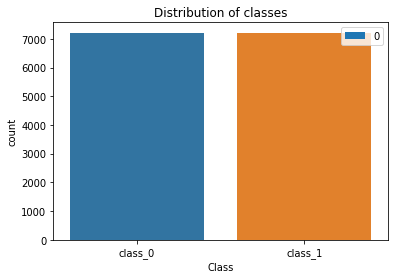

In [51]:
nm = NearMiss()
train_X, train_y = nm.fit_sample(train_X, train_y.ravel())

labels = ['class_0', 'class_1']
classes = pd.DataFrame([sum(train_y == 0), sum(train_y == 1)])
classes.plot(kind = 'bar', rot=0)
plt.title("Distribution of classes")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

g = sns.countplot(train_y)
g.set_xticklabels(labels)

print("After Undersampling, counts of label '1': {}".format(sum(train_y == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(train_y == 0)))

In [52]:
# Performing Logistic Regression on the data after imputation and balancing
start_time = time.time()
model = LogisticRegression(random_state=0, max_iter=400).fit(train_X, train_y.ravel())
scores = cross_val_score(model, train_X, train_y, cv=10)
print('Cross-Validation Accuracy Scores', scores)
print("--- %s seconds ---" % (time.time() - start_time))

Cross-Validation Accuracy Scores [0.46431046 0.5959806  0.64008322 0.69556172 0.72676838 0.72676838
 0.74895978 0.79056865 0.78294036 0.66366158]
--- 6.876060724258423 seconds ---


In [53]:
# Average training accuracy 
scores.mean()

0.6835603126865263

In [54]:
# Predict values according to the test set given and find the accuracy
pred_y = model.predict(test_X)
print(accuracy_score(test_y, pred_y))

0.7410901467505241


In [55]:
confusion_matrix(test_y, pred_y)

array([[1356,  457],
       [  37,   58]])

In [56]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85      1813
         1.0       0.11      0.61      0.19        95

    accuracy                           0.74      1908
   macro avg       0.54      0.68      0.52      1908
weighted avg       0.93      0.74      0.81      1908



# Iterative Imputation with NearMiss 

In [57]:
# Applying Iterative Imputation in order to solve the missing values problem
start_time = time.time()
imp = IterativeImputer(max_iter=10, sample_posterior=True, n_nearest_features=10,  
                       imputation_order='descending', verbose=0)
iterativeDf = pd.DataFrame(imp.fit_transform(data_norm), columns=data_norm.columns)
print("--- %s seconds ---" % (time.time() - start_time))

--- 9.97446060180664 seconds ---


In [58]:
# Check if any null values exist
d = iterativeDf.isna().sum()
d.sort_values(ascending=False)

class     0
Attr32    0
Attr30    0
Attr29    0
Attr28    0
         ..
Attr38    0
Attr37    0
Attr36    0
Attr35    0
Attr1     0
Length: 65, dtype: int64

In [59]:
# Splitting the dataset for training and validation
X = iterativeDf.loc[:, iterativeDf.columns != 'class'].to_numpy()
y = iterativeDf['class'].to_numpy().reshape(-1, 1)
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2)
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(7631, 64)
(1908, 64)
(7631, 1)
(1908, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After Undersampling, counts of label '1': 401
After Undersampling, counts of label '0': 401


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


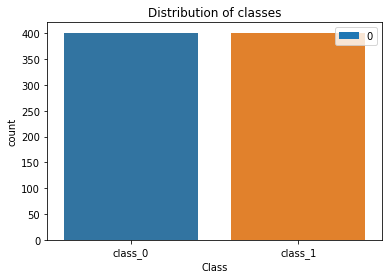

In [60]:
# Performing NearMiss on the dataset to address the problem of imbalanced data
nm = NearMiss()
train_X, train_y = nm.fit_sample(train_X, train_y.ravel())

labels = ['class_0', 'class_1']
classes = pd.DataFrame([sum(train_y == 0), sum(train_y == 1)])
classes.plot(kind = 'bar', rot=0)
plt.title("Distribution of classes")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

g = sns.countplot(train_y)
g.set_xticklabels(labels)

print("After Undersampling, counts of label '1': {}".format(sum(train_y == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(train_y == 0)))

In [61]:
# Performing Logistic Regression on the data after imputation and balancing
start_time = time.time()
model = LogisticRegression(random_state=0, max_iter=400).fit(train_X, train_y.ravel())
scores = cross_val_score(model, train_X, train_y, cv=10)
print('Cross-Validation Accuracy Scores', scores)
print("--- %s seconds ---" % (time.time() - start_time))

Cross-Validation Accuracy Scores [0.77777778 0.77777778 0.8125     0.825      0.725      0.775
 0.75       0.8        0.8375     0.7875    ]
--- 0.32695555686950684 seconds ---


In [62]:
scores.mean()

0.7868055555555555

In [63]:
# Predict values according to the test set given and find the accuracy
pred_y = model.predict(test_X)
print(accuracy_score(test_y, pred_y))

0.6834381551362684


In [64]:
confusion_matrix(test_y, pred_y)

array([[1242,  552],
       [  52,   62]])

In [65]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80      1794
         1.0       0.10      0.54      0.17       114

    accuracy                           0.68      1908
   macro avg       0.53      0.62      0.49      1908
weighted avg       0.91      0.68      0.77      1908



# Iterative Imputation with SMOTE

In [66]:
# Splitting the dataset for training and validation

X = iterativeDf.loc[:, iterativeDf.columns != 'class'].to_numpy()
y = iterativeDf['class'].to_numpy().reshape(-1, 1)
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


After Oversampling, counts of label '1': 7236
After Oversampling, counts of label '0': 7236


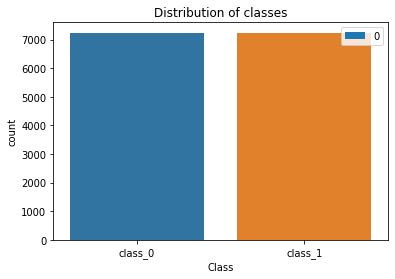

In [67]:
# Performing SMOTE on the dataset to address the problem of imbalanced data
sm = SMOTE(random_state = 2)
train_X, train_y = sm.fit_sample(train_X, train_y.ravel())

labels = ['class_0', 'class_1']
classes = pd.DataFrame([sum(train_y == 0), sum(train_y == 1)])
classes.plot(kind = 'bar', rot=0)
plt.title("Distribution of classes")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

g = sns.countplot(train_y)
g.set_xticklabels(labels)

print("After Oversampling, counts of label '1': {}".format(sum(train_y == 1)))
print("After Oversampling, counts of label '0': {}".format(sum(train_y == 0)))

In [68]:
# Performing Logistic Regression on the data after balancing it
start_time = time.time()
model = LogisticRegression(random_state=0, max_iter=400).fit(train_X, train_y.ravel())
scores = cross_val_score(model, train_X, train_y, cv=10)
print('Cross-Validation Accuracy Scores', scores)
print("--- %s seconds ---" % (time.time() - start_time))

Cross-Validation Accuracy Scores [0.72582873 0.74309392 0.7373877  0.74360746 0.74153421 0.70283345
 0.72149274 0.74568072 0.74429855 0.76641327]
--- 8.114916563034058 seconds ---


In [69]:
scores.mean()

0.7372170751449942

In [70]:
# Predict values according to the test set given and find the accuracy
pred_y = model.predict(test_X)
print(accuracy_score(test_y, pred_y))

0.7348008385744235


In [71]:
confusion_matrix(test_y, pred_y)

array([[1334,  454],
       [  52,   68]])

In [72]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.96      0.75      0.84      1788
         1.0       0.13      0.57      0.21       120

    accuracy                           0.73      1908
   macro avg       0.55      0.66      0.53      1908
weighted avg       0.91      0.73      0.80      1908



# Feature Selection

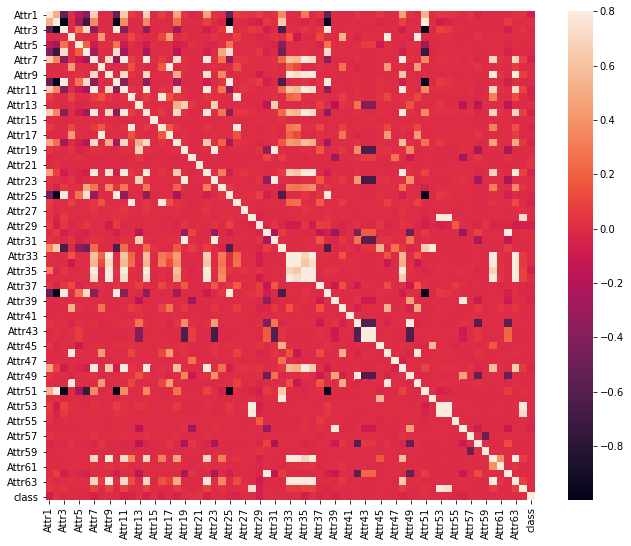

In [73]:
# Visualization of the correlation among all the attributes. There exists multicollinearity in the dataset.
correlation_matrix = data_norm.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()

## KNN Imputation with SMOTE

### SelectKBest()

In [74]:
# Feature Selection using SelectKBest()
X = knnImputedDf.iloc[:,:-1]
y = knnImputedDf.iloc[:,-1]
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2)
test = SelectKBest(score_func=f_classif, k=8)
fit = test.fit(train_X, train_y.ravel())

In [75]:
# Performing SMOTE on the dataset to address the problem of imbalanced data
sm = SMOTE(random_state = 0)
train_X, train_y = sm.fit_sample(train_X, train_y.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [76]:
# Performing Logistic Regression on the dataset 
start_time = time.time()
model = LogisticRegression(random_state=0, max_iter=400).fit(train_X, train_y.ravel())
#print(model.score(test_X, test_y))
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.6935746669769287 seconds ---


In [77]:
scores = cross_val_score(model, train_X, train_y, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.71487889 0.73564014 0.69757785 0.72110727 0.70290859 0.74168975
 0.70637119 0.72853186 0.70844875 0.7132964 ]


In [78]:
scores.mean()

0.7170450689645257

In [79]:
pred_y = model.predict(test_X)
print(accuracy_score(test_y, pred_y))
print(confusion_matrix(test_y, pred_y))
print(classification_report(test_y, pred_y))

0.7269392033542977
[[1323  479]
 [  42   64]]
              precision    recall  f1-score   support

         0.0       0.97      0.73      0.84      1802
         1.0       0.12      0.60      0.20       106

    accuracy                           0.73      1908
   macro avg       0.54      0.67      0.52      1908
weighted avg       0.92      0.73      0.80      1908



In [80]:
mask = fit.get_support(indices=True)
data_new = data.iloc[:,mask]
data_new.head()

,Attr1,Attr2,Attr3,Attr10,Attr25,Attr35,Attr38,Attr51
0,0.096557,0.13718,0.8528,0.86282,0.80007,0.00697,0.86282,0.13718
1,0.30458,0.13686,0.75567,0.86314,0.80077,0.37179,0.86314,0.13261
2,0.13495,0.16866,0.71295,0.83134,0.55143,0.15185,0.83134,0.16866
3,0.26775,0.11341,0.78931,0.88659,0.62958,0.33267,0.88659,0.11211
4,0.046283,0.094199,0.47172,0.9058,0.86719,0.034208,0.9058,0.070806


### RFE

In [81]:
# Feature Selection using RFE()
model = LogisticRegression(random_state=0, max_iter=400)
X = knnImputedDf.iloc[:,:-1]
y = knnImputedDf.iloc[:,-1]
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2)
test = RFE(model, 10)
fit = test.fit(train_X, train_y.ravel())

In [82]:
# Performing SMOTE on the dataset to address the problem of imbalanced data
sm = SMOTE(random_state = 0)
train_X, train_y = sm.fit_sample(train_X, train_y.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [83]:
# Performing Logistic Regression on the dataset 
start_time = time.time()
model = LogisticRegression(random_state=0, max_iter=400).fit(train_X, train_y.ravel())
#print(model.score(test_X, test_y))
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.827324390411377 seconds ---


In [84]:
scores = cross_val_score(model, train_X, train_y, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.73753463 0.70429363 0.70616771 0.7006237  0.71794872 0.71379071
 0.69022869 0.73319473 0.72765073 0.72210672]


In [85]:
scores.mean()

0.7153539966559357

In [86]:
pred_y = model.predict(test_X)
print(accuracy_score(test_y, pred_y))
print(confusion_matrix(test_y, pred_y))
print(classification_report(test_y, pred_y))

0.7190775681341719
[[1310  498]
 [  38   62]]
              precision    recall  f1-score   support

         0.0       0.97      0.72      0.83      1808
         1.0       0.11      0.62      0.19       100

    accuracy                           0.72      1908
   macro avg       0.54      0.67      0.51      1908
weighted avg       0.93      0.72      0.80      1908



In [87]:
mask = fit.get_support(indices=True)
data_new = data.iloc[:,mask]
data_new.head()

,Attr1,Attr2,Attr7,Attr12,Attr14,Attr16,Attr22,Attr35,Attr38,Attr48
0,0.096557,0.13718,0.096557,0.70389,0.096557,0.70389,0,0.00697,0.86282,0
1,0.30458,0.13686,0.37602,2.8355,0.37602,2.9693,0.37291,0.37179,0.86314,0.34257
2,0.13495,0.16866,0.17653,1.0467,0.17653,1.137,0.10746,0.15185,0.83134,0.092228
3,0.26775,0.11341,0.33261,2.9668,0.33261,3.3578,0.33258,0.33267,0.88659,0.28437
4,0.046283,0.094199,0.046283,0.65366,0.046283,0.78093,0.030548,0.034208,0.9058,0.003268


#Mean Imputation with SMOTE 

### RFE

In [88]:
sm = SMOTE(random_state = 2)

X = mean_imputed_df.loc[:, mean_imputed_df.columns != 'class'].to_numpy()
y = mean_imputed_df['class'].to_numpy().reshape(-1, 1)

train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2)
train_X, train_y = sm.fit_resample(train_X, train_y.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [89]:
# Feature Selection using RFE()
test = RFE(model, 10)
fit = test.fit(train_X, train_y.ravel())

In [90]:
start_time = time.time()
model = LogisticRegression(random_state=0, max_iter=400).fit(train_X, train_y)
print(model.score(test_X, test_y))
print("--- %s seconds ---" % (time.time() - start_time))

0.70020964360587
--- 0.750067949295044 seconds ---


In [91]:
scores = cross_val_score(model, train_X, train_y, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.72645429 0.74861496 0.7098338  0.71121884 0.70914127 0.71814404
 0.72091413 0.716759   0.6971587  0.71586972]


In [92]:
scores.mean()

0.7174108745438386

In [93]:
pred_y = model.predict(test_X)
print(accuracy_score(test_y, pred_y))
print(confusion_matrix(test_y, pred_y))
print(classification_report(test_y, pred_y))

0.70020964360587
[[1276  529]
 [  43   60]]
              precision    recall  f1-score   support

         0.0       0.97      0.71      0.82      1805
         1.0       0.10      0.58      0.17       103

    accuracy                           0.70      1908
   macro avg       0.53      0.64      0.50      1908
weighted avg       0.92      0.70      0.78      1908



In [94]:
mask = fit.get_support(indices=True)
data_new = data.iloc[:,mask]
data_new.head()

,Attr8,Attr9,Attr11,Attr14,Attr17,Attr34,Attr36,Attr40,Attr46,Attr63
0,6.2899,0.61457,0.096557,0.096557,7.2899,3.0457,0.61457,5.867,7.0125,4.4801
1,6.307,2.49970,0.37607,0.37602,7.307,15.548,2.4997,2.0459,5.3464,18.849
2,4.9292,0.76021,0.1766,0.17653,5.9292,3.607,0.76021,3.1346,5.2248,4.5074
3,7.8176,1.70250,0.33261,0.33261,8.8176,12.079,1.7025,5.4824,8.0405,15.186
4,9.6158,1.13950,0.046283,0.046283,10.616,11.733,1.1395,3.153,5.271,16.093


###Select K-Best 

In [95]:
# Feature Selection using SelectKBest()
sm = SMOTE(random_state = 2)

X = mean_imputed_df.loc[:, mean_imputed_df.columns != 'class'].to_numpy()
y = mean_imputed_df['class'].to_numpy().reshape(-1, 1)

train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2)
train_X, train_y = sm.fit_resample(train_X, train_y.ravel())

test = SelectKBest(score_func=f_classif, k=10)
fit = test.fit(train_X, train_y.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [96]:
# Performing Logistic Regression on the dataset 
start_time = time.time()
model = LogisticRegression(random_state=0, max_iter=400).fit(train_X, train_y.ravel())
print(model.score(test_X, test_y))
print("--- %s seconds ---" % (time.time() - start_time))

0.7274633123689728
--- 0.7601704597473145 seconds ---


In [97]:
scores = cross_val_score(model, train_X, train_y, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.69417476 0.69417476 0.70457698 0.70873786 0.69764216 0.69902913
 0.70992366 0.69049271 0.71963914 0.69743234]


In [98]:
scores.mean()

0.7015823500593381

In [99]:
pred_y = model.predict(test_X)
print(accuracy_score(test_y, pred_y))
print(confusion_matrix(test_y, pred_y))
print(classification_report(test_y, pred_y))

0.7274633123689728
[[1330  486]
 [  34   58]]
              precision    recall  f1-score   support

         0.0       0.98      0.73      0.84      1816
         1.0       0.11      0.63      0.18        92

    accuracy                           0.73      1908
   macro avg       0.54      0.68      0.51      1908
weighted avg       0.93      0.73      0.80      1908



In [100]:
mask = fit.get_support(indices=True)
data_new = data.iloc[:,mask]
data_new.head()

,Attr1,Attr7,Attr11,Attr14,Attr18,Attr22,Attr29,Attr35,Attr48,Attr55
0,0.096557,0.096557,0.096557,0.096557,0.096557,0,2.9013,0.00697,0,679.47
1,0.30458,0.37602,0.37607,0.37602,0.37602,0.37291,2.904,0.37179,0.34257,605.75
2,0.13495,0.17653,0.1766,0.17653,0.17653,0.10746,3.0373,0.15185,0.092228,776.85
3,0.26775,0.33261,0.33261,0.33261,0.33261,0.33258,2.289,0.33267,0.28437,153.55
4,0.046283,0.046283,0.046283,0.046283,0.046283,0.030548,3.1208,0.034208,0.003268,623.05


#Iterative Imputation with SMOTE

# SelectKBest

In [101]:
# Feature Selection using SelectKBest()
X = iterativeDf.iloc[:,:-1]
y = iterativeDf.iloc[:,-1]
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2)
test1 = SelectKBest(score_func=f_classif, k=10)
fit = test1.fit(train_X, train_y.ravel())

In [102]:
# Performing SMOTE on the dataset to address the problem of imbalanced data
sm = SMOTE(random_state = 0)
train_X, train_y = sm.fit_sample(train_X, train_y.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [103]:
# Performing Logistic Regression on the dataset 
start_time = time.time()
model = LogisticRegression(random_state=0, max_iter=400).fit(train_X, train_y.ravel())
print(model.score(test_X, test_y))
print("--- %s seconds ---" % (time.time() - start_time))

0.7568134171907757
--- 0.838181734085083 seconds ---


In [104]:
scores = cross_val_score(model, train_X, train_y, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.723566   0.72494817 0.71438451 0.72821577 0.71300138 0.72406639
 0.72060858 0.71161826 0.74688797 0.71991701]


In [105]:
scores.mean()

0.7227214028929984

In [106]:
pred_y = model.predict(test_X)
print(accuracy_score(test_y, pred_y))
print(confusion_matrix(test_y, pred_y))
print(classification_report(test_y, pred_y))

0.7568134171907757
[[1381  412]
 [  52   63]]
              precision    recall  f1-score   support

         0.0       0.96      0.77      0.86      1793
         1.0       0.13      0.55      0.21       115

    accuracy                           0.76      1908
   macro avg       0.55      0.66      0.53      1908
weighted avg       0.91      0.76      0.82      1908



In [107]:
mask = fit.get_support(indices=True)
data_new = data.iloc[:,mask]
data_new.head()

,Attr1,Attr7,Attr11,Attr12,Attr14,Attr16,Attr22,Attr26,Attr29,Attr35
0,0.096557,0.096557,0.096557,0.70389,0.096557,0.70389,0,0.70389,2.9013,0.00697
1,0.30458,0.37602,0.37607,2.8355,0.37602,2.9693,0.37291,2.4472,2.904,0.37179
2,0.13495,0.17653,0.1766,1.0467,0.17653,1.137,0.10746,0.8905,3.0373,0.15185
3,0.26775,0.33261,0.33261,2.9668,0.33261,3.3578,0.33258,2.786,2.289,0.33267
4,0.046283,0.046283,0.046283,0.65366,0.046283,0.78093,0.030548,0.78093,3.1208,0.034208


# RFE

In [108]:
# Feature Selection using RFE()
model = LogisticRegression(random_state=0, max_iter=400)
X = iterativeDf.iloc[:,:-1]
y = iterativeDf.iloc[:,-1]
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2)
test = RFE(model, 10)
fit = test.fit(train_X, train_y.ravel())

In [109]:
# Performing SMOTE on the dataset to address the problem of imbalanced data
sm = SMOTE(random_state = 0)
train_X, train_y = sm.fit_sample(train_X, train_y.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [110]:
# Performing Logistic Regression on the dataset 
start_time = time.time()
model = LogisticRegression(random_state=0, max_iter=400).fit(train_X, train_y.ravel())
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.7014727592468262 seconds ---


In [111]:
scores = cross_val_score(model, train_X, train_y, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.71359223 0.72746186 0.72260749 0.70596394 0.72330097 0.72052705
 0.72676838 0.73925104 0.71616933 0.7147814 ]


In [112]:
scores.mean()

0.721042368289089

In [113]:
pred_y = model.predict(test_X)
print(accuracy_score(test_y, pred_y))
print(confusion_matrix(test_y, pred_y))
print(classification_report(test_y, pred_y))

0.7279874213836478
[[1333  482]
 [  37   56]]
              precision    recall  f1-score   support

         0.0       0.97      0.73      0.84      1815
         1.0       0.10      0.60      0.18        93

    accuracy                           0.73      1908
   macro avg       0.54      0.67      0.51      1908
weighted avg       0.93      0.73      0.80      1908



In [114]:
mask = fit.get_support(indices=True)
data_new = data.iloc[:,mask]
data_new.head()

,Attr7,Attr11,Attr14,Attr16,Attr18,Attr26,Attr33,Attr34,Attr36,Attr63
0,0.096557,0.096557,0.096557,0.70389,0.096557,0.70389,3.0457,3.0457,0.61457,4.4801
1,0.37602,0.37607,0.37602,2.9693,0.37602,2.4472,16.046,15.548,2.4997,18.849
2,0.17653,0.1766,0.17653,1.137,0.17653,0.8905,3.607,3.607,0.76021,4.5074
3,0.33261,0.33261,0.33261,3.3578,0.33261,2.786,12.219,12.079,1.7025,15.186
4,0.046283,0.046283,0.046283,0.78093,0.046283,0.78093,15.61,11.733,1.1395,16.093


#Soft Imputation with SMOTE

# SelectKBest

In [115]:
# Feature Selection using SelectKBest()
SoftImputeDf = pd.DataFrame(new_df,columns=data_norm.columns)
X = SoftImputeDf.iloc[:,:-1]
y = SoftImputeDf.iloc[:,-1]
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2)
test1 = SelectKBest(score_func=f_classif, k=10)
fit = test1.fit(train_X, train_y.ravel())

In [116]:
# Performing SMOTE on the dataset to address the problem of imbalanced data
sm = SMOTE(random_state = 0)
train_X, train_y = sm.fit_sample(train_X, train_y.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [117]:
# Performing Logistic Regression on the dataset 
start_time = time.time()
model = LogisticRegression(random_state=0, max_iter=400).fit(train_X, train_y.ravel())
print(model.score(test_X, test_y))
print("--- %s seconds ---" % (time.time() - start_time))

0.7374213836477987
--- 0.9600577354431152 seconds ---


In [118]:
scores = cross_val_score(model, train_X, train_y, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.6959226  0.70836213 0.7049067  0.70421562 0.69017981 0.68603043
 0.69156293 0.697787   0.69986169 0.67565698]


In [119]:
scores.mean()

0.695448588724131

In [120]:
pred_y = model.predict(test_X)
print(accuracy_score(test_y, pred_y))
print(confusion_matrix(test_y, pred_y))
print(classification_report(test_y, pred_y))

0.7374213836477987
[[1333  459]
 [  42   74]]
              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84      1792
         1.0       0.14      0.64      0.23       116

    accuracy                           0.74      1908
   macro avg       0.55      0.69      0.53      1908
weighted avg       0.92      0.74      0.80      1908



In [121]:
mask = fit.get_support(indices=True)
data_new = data.iloc[:,mask]
data_new.head()

,Attr1,Attr7,Attr11,Attr14,Attr21,Attr22,Attr29,Attr35,Attr39,Attr56
0,0.096557,0.096557,0.096557,0.096557,0.82983,0,2.9013,0.00697,0.011341,0.32018
1,0.30458,0.37602,0.37607,0.37602,0.65534,0.37291,2.904,0.37179,0.14874,0.14874
2,0.13495,0.17653,0.1766,0.17653,1.1209,0.10746,3.0373,0.15185,0.19975,0.19975
3,0.26775,0.33261,0.33261,0.33261,0.73416,0.33258,2.289,0.33267,0.1954,0.1954
4,0.046283,0.046283,0.046283,0.046283,0.99457,0.030548,3.1208,0.034208,0.030021,0.030021


# RFE

In [122]:
# Feature Selection using RFE()
model = LogisticRegression(random_state=0, max_iter=400)
X = SoftImputeDf.iloc[:,:-1]
y = SoftImputeDf.iloc[:,-1]
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2)
test = RFE(model, 10)
fit = test.fit(train_X, train_y.ravel())

In [123]:
# Performing SMOTE on the dataset to address the problem of imbalanced data
sm = SMOTE(random_state = 0)
train_X, train_y = sm.fit_sample(train_X, train_y.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [124]:
# Performing Logistic Regression on the dataset 
start_time = time.time()
model = LogisticRegression(random_state=0, max_iter=400).fit(train_X, train_y.ravel())
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.7626574039459229 seconds ---


In [125]:
scores = cross_val_score(model, train_X, train_y, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.70034602 0.6982699  0.72387543 0.68512111 0.72802768 0.67197232
 0.7100346  0.70588235 0.70221607 0.6932133 ]


In [126]:
scores.mean()

0.7018958774645592

In [127]:
pred_y = model.predict(test_X)
print(accuracy_score(test_y, pred_y))
print(confusion_matrix(test_y, pred_y))
print(classification_report(test_y, pred_y))

0.7410901467505241
[[1339  461]
 [  33   75]]
              precision    recall  f1-score   support

         0.0       0.98      0.74      0.84      1800
         1.0       0.14      0.69      0.23       108

    accuracy                           0.74      1908
   macro avg       0.56      0.72      0.54      1908
weighted avg       0.93      0.74      0.81      1908



In [128]:
mask = fit.get_support(indices=True)
data_new = data.iloc[:,mask]
data_new.head()

,Attr1,Attr7,Attr9,Attr14,Attr16,Attr17,Attr22,Attr35,Attr36,Attr48
0,0.096557,0.096557,0.61457,0.096557,0.70389,7.2899,0,0.00697,0.61457,0
1,0.30458,0.37602,2.49970,0.37602,2.9693,7.307,0.37291,0.37179,2.4997,0.34257
2,0.13495,0.17653,0.76021,0.17653,1.137,5.9292,0.10746,0.15185,0.76021,0.092228
3,0.26775,0.33261,1.70250,0.33261,3.3578,8.8176,0.33258,0.33267,1.7025,0.28437
4,0.046283,0.046283,1.13950,0.046283,0.78093,10.616,0.030548,0.034208,1.1395,0.003268
